# Links:
[sigfox configuration](https://build.sigfox.com/sigfox-radio-configurations-rc)


[wireless and mobile networking](https://www.cse.wustl.edu/~jain/cse574-16/)

[Sigfox network emulator](chrome-extension://efaidnbmnnnibpcajpcglclefindmkaj/https://www.sigfox.com/center/download/SIFOX%20network%20emulator%20User%20Guide_0.pdf)

In [29]:
import simpy
import numpy as np
import math
import matplotlib.pyplot as plt

In [30]:
class Space(object):
    def __init__(self, env, num_worker):
        self.env = env
        self.worker = simpy.Resource(env, num_worker)

In [31]:
from scipy.spatial.transform import Rotation as R

In [32]:
class Agent(object):
    def __init__(self, **kwargs):
        self.gp = kwargs['gp'] # global position
        self.ln = kwargs['ln'] # number of NLOS paths
        self.o = kwargs['o'] # euler angle
        # self.t = kwargs['t'] direction vector
        self.phi = kwargs['phi'] # beamforming angle

In [33]:
global c
c = 3 * 10e8

def path_gain(f, d):
    r'''
    LOS path gain rho = c / (4 * pi * f * d) * Kappa (attenuation)
    '''
    return c / (4 * math.pi * f * d) #* kappa(f, d)

def kappa(f, d):
    r'''
    attenuation coefficient depending on freq and distance
    For mmWave, the attenuation over distance is set to 16 dB / km
    '''
    return 16 * d / 1000

def antenna_gain(phi, theta, phi_t, theta_t):
    r'''
    G = 1 for omnidirectional antennas
    G = sqrt(G_0) when angle in range or 0 when angle out of antennas range for other antennas
    phi: [phi_0, phi_1] pitch range
    theta: [theta_0, theta_1] 
    '''
    # if 
    return np.sqrt(4 * math.pi / (theta[1] * phi[1]))

def steering_vector():
    ...

def channel_matrix(d, fc, fk, B, delta_f, phi, theta, phi_t, theta_t):
    r'''
    channel matrix modeling channel response for k-th subcarrier
    d: distance between station and equipment (m)
    fc: central freqency (Hz)
    fk: k-th subcarrier freq(Hz)
    B: Synchronization offset
    '''
    ck = fc / fk                    # ration between central freq and subcarrier freq
    tau = d / c + B                 # signal delay
    epsl = 2 * math.pi * fc * tau   # 
    kappa = 16 * d / 1000           # attenuation coef depending on signal freq and distance

    H = ck * path_gain(fc, d) * np.exp(1j * (epsl + 2 * math.pi * delta_f * tau)) * antenna_gain(phi, theta, phi_t, theta_t)

    return H

In [34]:
fc = 862e6

channel_matrix(10, 2e8, 2.1e8, 1, 1, [0,1], [0,1], 1, 1)

(-0.20149631590468647-0.3490017733935374j)

In [35]:
n = 100
n_s = 20

coordinate = np.random.random([n, 3])
station_idx = np.random.choice(n, n_s)
bs = coordinate[station_idx]
ue = coordinate[~station_idx]

In [36]:
from scipy.io.wavfile import read, write

C:\Users\lenovo\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  """Entry point for launching an IPython kernel.


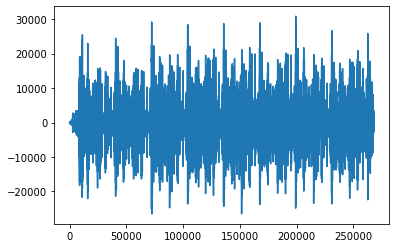

In [42]:
fs, sig = read('sample1.wav')

plt.plot(sig[:, 1])

d:\Users\lenovo\AppData\Local\Programs\Python\Python37\lib\site-packages\matplotlib\cbook\__init__.py:1317: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


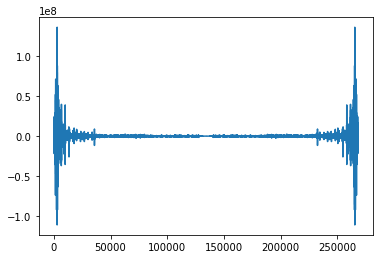

In [46]:
# precode fft
sig_f = np.fft.fft(sig[:, 1])


In [3]:
a = Agent(gp=1)
a.gp

1

3|4